<a href="https://colab.research.google.com/github/shan-gao-qd/tube_challenge/blob/main/tube_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 <h1><center>Solving the Tube Challenge with Reinforcement Learning</center></h1>

We strongly recommend opening our project notebook in Colab, as some visualisations do not render when the notebook is downloaded. https://colab.research.google.com/drive/1LqKcKKoerujXgl9hubMj-0dyQ_1ZgRPD?usp=sharing

<h2> Table of Content</h2> 

* [Introduction](#intro) 
* [Necessary libraries and datasets](#loading)
* [Data description](#data)
* [Data preprocessing](#preprocess)
* [Methods](#methods)
  * [Nearest Neighbor Algorithm](#nn)
  * [Q Learning](#q)
  * [Double Q Learning](#dq)
  * [Deep Q Network](#dqn)
  * [Implementation details](#details)
* [Experimental Results and Discussions](#results)
  * [Performance](#performance)
  * [Comparison with other state-of-the-art methods](#Comparison)
* [References](#references)

   

<a name="intro"></a>
# Introduction

The London Tube has gained an iconic status since its ancestor, the Metropolitan Railway first opened in 1863. Whether printed on mugs and sweatshirts or copied in the far reaches of the world, the Tube Logo has come to represent and symbolize the city of London. From its glorious beginnings as the first underground passenger railway to the extensive network we know today, the Tube has a rich history that we wanted to honour with this project. In 2021, the tube had expanded to 11 lines and could handle up to 5 million passenger journeys a day, making it the 12th busiest metro system in the world. As we celebrate the opening of the Elizabeth Line, and the continued development of the London Tube, we believed it particularly interesting to find a new approach to planning for the Tube Challenge.

My aim in this project is to use Reinforcement Learning to complete a slightly modified version of the Tube Challenge. To complete the Tube Challenge, one must simply travel to all London Underground stations as fast as possible. To do so, the participant may connect stations on foot, or by using other forms of public transport. In its core however, this challenge is a routing problem where participants must come up with the fastest and most efficient path to navigate the tube network. This competition has drawn a lot of attention over the years and the best performances are even tracked as a Guinness World Record since 1960.

#### Travelling Salesman Problem

The Tube Challenge is a generalisation of the famous Travelling Salesman Problem (TSP) which is a typical optimization problem, where one has to find the shortest route to visit different locations. TSP are np-hard problems, meaning that they are exponentially hard to solve with brute force. To go pass this issue, many optimization techniques exist to solve TSPs from dynamic programming, branch and bound algorithms to nearest neighbours approximations or colonies optimizations.

#### Why use Reinforcement Learning?
Even though TSPs can be solved, Reinforcement Learning theoretically holds many advantages compared to classical optimization techniques :

It offers a general framework for all problems
It enables a "live" decision making algorithm
It is more robust to unknowns and aleatory perturbations

####The setup of my Tube Challenge

Implementing the Tube Challenge poses some noteworthy difficulties:

- Allowing for multiple modes of transport (walking and other public transport) is very challenging, as it adds layers of complexity and unknown variables to an already complex problem
- No reliable data exist on the time it takes to go from one station to another
- Not accounting for the cost (in time) of changing line could lead to a big bias in our final optimal path

Henceforth, the setup of our project is slightly different from the classic Tube Challenge:

- We will work with all of the 274 stations of the tube network 
- The tube will be the only mode of transport allowed to complete the challenge
- Distance will be used as a proxy for time 
- We will implement an arbitrary 1km penalty (the average distance between 2 stations) for changing lines

This project is structured in the following way:

First, we model the tube network using real life data on the tube stations, lines and their connections. We then use this network to build a function that finds the shortest route between any two stations. Then, we implement a random policy and obtain the average distance and number of steps an agent could expect to take before completing the Tube Challenge. Subsequently, we compare these results with the results we obtain from our Q learning and double Q learning algorithms. We show that they exhibit significantly better performances, and we use our shortest route function to unpack the optimal path from our algorithms. We then consider the use of a deep Q network, and we conclude by interpreting our results.

<a name="loading"></a>
#Necessary libraries and datasets

Necessary libraries / packages for this notebook:

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import os
import statistics as st
import scipy.stats as stats

The data we will be using in this project is the source data of Wikimedia Commons [London Underground geographic maps](https://commons.wikimedia.org/wiki/London_Underground_geographic_maps). It is composed of three different CSV files defining the stations, the lines and the connections of the London Underground. The csv data is available [here](https://commons.wikimedia.org/wiki/London_Underground_geographic_maps/CSV).
To run this notebook, please put the three csv files under your current working directory.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/RLproject")

Mounted at /content/drive


In [ ]:
stations = pd.read_csv('stations.txt')
routes = pd.read_csv('routes.txt')
line_definitions = pd.read_csv('line_definitions.txt')

<a name="data"></a>
#Data Description: The London Underground Network

In [ ]:
print("Number of stations:", len(stations))
print("Number of lines:", len(routes))
print("Number of connections:", len(line_definitions))

Number of stations: 308
Number of lines: 13
Number of connections: 415


The `stations` dataframe contains 308 stations, and includes information on latitude and longitude, zone, and total lines of a station. 

In [ ]:
stations.head()

,id,latitude,longitude,name,display_name,zone,total_lines,rail,line
0,1,51.5028,-0.2801,Acton Town,Acton<br />Town,3.0,2,0,0
1,2,51.5143,-0.0755,Aldgate,NaN,1.0,2,0,1
2,3,51.5154,-0.0726,Aldgate East,Aldgate<br />East,1.0,2,0,2
3,4,51.5107,-0.0130,All Saints,All<br />Saints,2.0,1,0,3
4,5,51.5407,-0.2997,Alperton,NaN,4.0,1,0,4


The `routes` dataframe gives information about the 13 lines in the dataset.  

In [ ]:
routes.head()

,line,name,colour,stripe
0,1,Bakerloo Line,ab6612,NaN
1,3,Circle Line,f7dc00,NaN
2,6,Hammersmith & City Line,f5a6b3,NaN
3,7,Jubilee Line,767b7f,NaN
4,11,Victoria Line,0076bd,NaN


The `line_definitions` dataframe shows the connections between stations. Values of `station1` and `station2` match with the `id` in the `stations ` dataframe, and value of `line` matches with the `line ` in the `routes` dataframe.





In [ ]:
line_definitions.head()

,station1,station2,line
0,11,163,1
1,11,212,1
2,49,87,1
3,49,197,1
4,82,163,1


In this project we will often need to merge the information contained in each of these dataframes together. To do this, we generate a `connections` dataframe.

In [ ]:
connections = pd.DataFrame(columns=['line',	'line_name',	'line_colour', 'station1', 'station1_name', 'station1_long','station1_lat', 'station1_zone', 'station1_total_lines',	'station1_rail', 'station2', 'station2_name', 'station2_long','station2_lat', 'station2_zone', 'station2_total_lines',	'station2_rail'])
connections = connections.iloc[0:0]

In [ ]:
for index, row in line_definitions.iterrows():
  #append station information and line information by station_id and line_id
  connections = connections.append({'line': row[2],
                                    'line_name': routes[routes['line']==row[2]]['name'].item(),
                                    'line_colour': routes[routes['line']==row[2]]['colour'].item(),
                                    'station1': row[0],
                                    'station1_name': stations[stations['id']==row[0]]['name'].item(),
                                    'station1_long': stations[stations['id']==row[0]]['longitude'].item(),
                                    'station1_lat': stations[stations['id']==row[0]]['latitude'].item(),
                                    'station1_zone': stations[stations['id']==row[0]]['zone'].item(),
                                    'station1_total_lines': stations[stations['id']==row[0]]['total_lines'].item(),
                                    'station1_rail': stations[stations['id']==row[0]]['rail'].item(),
                                    'station2': row[1],
                                    'station2_name': stations[stations['id']==row[1]]['name'].item(),
                                    'station2_long': stations[stations['id']==row[1]]['longitude'].item(),
                                    'station2_lat': stations[stations['id']==row[1]]['latitude'].item(),
                                    'station2_zone': stations[stations['id']==row[1]]['zone'].item(),
                                    'station2_total_lines': stations[stations['id']==row[1]]['total_lines'].item(),
                                    'station2_rail': stations[stations['id']==row[1]]['rail'].item(),
                                    }, ignore_index=True)

Next, we visualise the London Underground Network.

In [ ]:
edgelist = connections[['station1', 'station2', 'line_colour']]
nodelist = stations[['id','latitude','longitude']]

In [ ]:
g = nx.Graph()
for i, elrow in edgelist.iterrows():
    g.add_edge(elrow[0], elrow[1], **elrow[2:].to_dict())
for i, nlrow in nodelist.iterrows():
    nx.set_node_attributes(g, {nlrow['id']:  nlrow[1:].to_dict()})  

In [ ]:
node_positions_as_dict = {x[0]: x[1] for x in list(g.nodes(data=True))}
node_positions_final = {key: value for key, value in node_positions_as_dict.items()}
node_positions = {node[0]: (node[1]['longitude'], node[1]['latitude']) for node in list(g.nodes(data=True))}

In [ ]:
#Convert HEX colours to RGB colours
line_colours = {
        'ab6612': (171, 102, 18),
        '0076bd': (0, 118, 189),
        'f7dc00': (247, 220, 0),
        'f5a6b3': (245, 166, 179),
        '767b7f': (118, 123, 127),
        '0d6928': (0, 114, 41),
        'df002c': (220, 36, 31),
        '8b004c': (117, 16, 86),
        'f3ba22': (243, 186, 34),
        '000000': (0, 0, 0),
        '002d73': (0, 45, 115),
        '89cbc1': (137, 203, 193),
        '00A77E':(0,167,126)
}

# Convert RGB colours to [0,1] scale
line_colours = {line: tuple([x / 255.0 for x in rgb]) for line, rgb in line_colours.items()}

# Set these as options for drawing graph
options = {
    'edge_color': [line_colours[data['line_colour']] for u,v,data in g.edges(data=True)],
    'width': 1.5,
    'alpha': 1,
}

Text(0.5, 1.0, 'Graph Representation of London Underground Network')

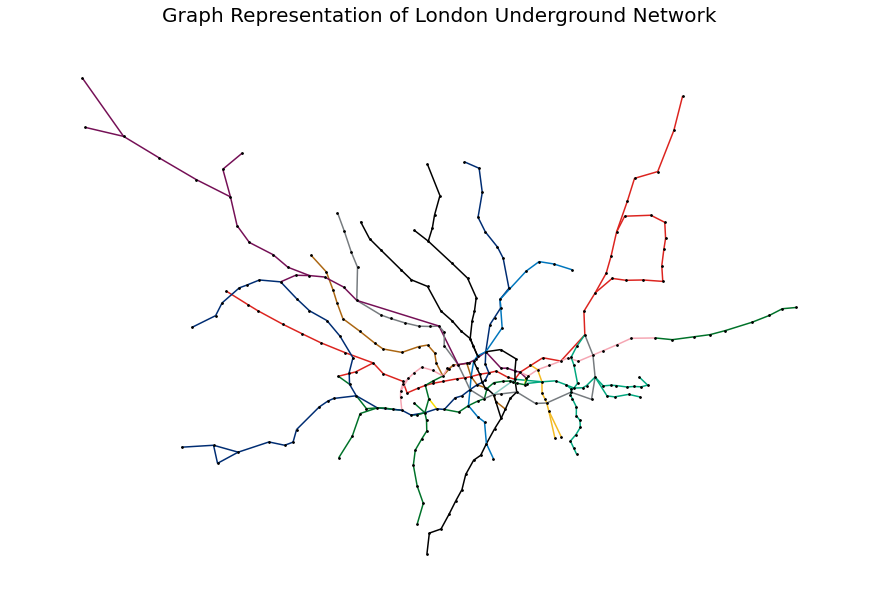

In [ ]:
plt.figure(figsize=(12, 8))
nx.draw(g, pos=node_positions, node_size=3, node_color='black', **options)
plt.title('Graph Representation of London Underground Network', size=20)

We managed to graph the entire tube network and differentiate the lines by colour. Each point in the graph represents a station. Upon a careful look at the graph, we can easily see that the optimal route to complete the Tube Challenge is not obvious.

Some lines in the graph seem to change colour unexplainably which can cause some confusion. This can be explained by the fact that, at times, some lines share the same tracks. For instance, the Hammersmith and city line (pink) shares a common track with the district line (green) from Barking station to Aldgate East station. In the graph however, this portion of the network is drawn in pink so that we could think it exclusively belongs to the Hammersmith and city line.

What may also seem confusing is that some edges appear to 'jump' between stations. For instance, the purple Metropolitan line in the center of the graph appears to be 'jumping' 5 stations from Wembley Park to Finchley Road. In reality however, the connection between these two stations exists and is simply a faster direct path through the Metropolitan line (1 stop) than through the Jubilee (6 stops).

This project uses the geographical distance between stations as a proxy for travel time. Distance between stations is calculated from longitude and latitude with the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula), which is a formula for calculating spherical distance.

In [ ]:
from math import cos, asin, sqrt, pi
## the Haversine formula for calculating distance
def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))

In [ ]:
## appending distances to the connections table
distances=[]
for index, row in connections.iterrows():
  distances.append(distance(row[6], row[5], row[13], row[12]))
connections['distance'] = distances

Now that we have a measure for distance, we can take a look into the lengths of the connections and paths between stations. A convenient way to do this is using the NetworkX library.

In [ ]:
graph_distance = nx.Graph()
for connection_id, connection in connections.iterrows():
    graph_distance.add_edge(connection['station1_name'], connection['station2_name'], weight = connection['distance'])

In [ ]:
#direct connections from a station
for i in ['Holborn', 'Euston', 'Waterloo']:
  print(f"\n{i} station is directly connected to:", *list(graph_distance.neighbors(i)), sep='\n\t', )


Holborn station is directly connected to:
	Chancery Lane
	Tottenham Court Road
	Covent Garden
	Russell Square

Euston station is directly connected to:
	Camden Town
	King's Cross St. Pancras
	Mornington Crescent
	Warren Street

Waterloo station is directly connected to:
	Embankment
	Lambeth North
	Southwark
	Westminster
	Kennington
	Bank


In [ ]:
## function for finding the shortest path between two stations
def shortest_route(start, end):
    journey_path = nx.shortest_path(graph_distance, start, end, weight='weight')
    journey_distance = nx.shortest_path_length(graph_distance, start, end, weight='weight')
    print(f'\nShortest Tube-Distance Journey from {start} to {end}:', *journey_path, sep='\n\t')
    print('\nJourney Distance:', journey_distance, 'kilometers')

In [ ]:
shortest_route('Waterloo', 'Euston')


Shortest Tube-Distance Journey from Waterloo to Euston:
	Waterloo
	Embankment
	Charing Cross
	Leicester Square
	Tottenham Court Road
	Goodge Street
	Warren Street
	Euston

Journey Distance: 3.4763636864651986 kilometers


We can see that the output above is indeed the optimal route from Waterloo to Euston (taking the Northern Line). We experimented with different station-pairs, and we found that the shortest_route function almost always produces very sensible output, with a few exceptions such as:

In [ ]:
shortest_route('Canary Wharf', 'Covent Garden')


Shortest Tube-Distance Journey from Canary Wharf to Covent Garden:
	Canary Wharf
	West India Quay
	Westferry
	Limehouse
	Shadwell
	Bank
	St. Paul's
	Chancery Lane
	Holborn
	Covent Garden

Journey Distance: 7.96831555899172 kilometers


The Jubilee line goes directly from Canary Wharf to Covent Garden, and is the fastest option with Google Maps estimating the journey time at 30 minutes. The output of the shortest_route function, however, includes 2 changes (DLR ==> Central ==> Piccadilly) and takes 34 min on Google Maps. We hence find that taking the shortest route might, at times, lengthens our journey time. Although the function is successful in finding the shortest path between two stations, it is not necessarily successful in finding the fastest way between these two stations.

This is an important finding which results from the assumption that distance can be used as a proxy for time. To fix this issue, we will assign a weight to line changes so as to account for the loss of time resulting from them. This penalty is calculated below and is equal to 1km.

<a name="preprocess"></a>
#Data Preprocessing

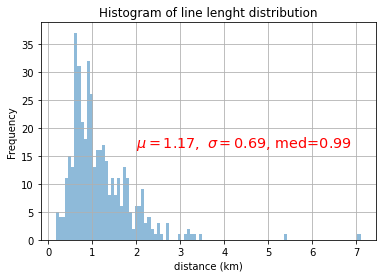

In [ ]:
distances=[]
for index, row in connections.iterrows():
    distances.append(distance(row[6], row[5], row[13], row[12]))
connections['distance'] = distances

Distances = pd.DataFrame(distances) # Create a pandas DataFrame out of the numpy array
Distances.plot.hist(alpha=0.5, bins=100, grid=True, legend=None)  # Pandas helper function to plot a hist. Uses matplotlib under the hood.
plt.xlabel("distance (km)")
plt.title("Histogram of line lenght distribution")

param = stats.norm.fit(distances)   # calculate sigma and mu
st.median(distances) # calculate median
plt.text(2,16.5, r'$\mu=1.17,\ \sigma=0.69$, med=0.99', color='r', fontsize = 'x-large')

plt.show()

We think it is reasonable to assume that the average transit time (changing line) is similar to the average time it takes to travel from one stop to another. Henceforth, we have calculated the distance between each station in the graph and concluded that, on average, each station was separated by 1.17km. Because the distance between central stations is smaller than the distance between peripheric stations, we observe a positive skewness in the distance distribution. Furthermore, it is unlikely that participants will change lines in the periphery of the network. For these reasons, we think it is more accurate to take the median distance as the penalty value for changing lines. 

The appropriate penalty for a line change will thus be 1km.

<h4> Splitting stations to station*line ('platforms')</h4>

To add transit costs, we must consider that a station is composed of platforms for different lines that participants must travel to in order to transit from one line to the next. In this project we will simply call them 'platforms'. The distance between each platform in the station is arbitrarily set to 1km (the median distance between two station) and is used as a way to simulate the time lost in transiting from one line to the next. 

For instance, instead of having one 'Euston Station', we would have one ' Northern Line Euston Station' and one 'Victoria line Euston Station ', and the `distance` between them will be set to 1km. 

An interesting extension of this project would be to experiment with difference transit penalty and compare the results. 



In [ ]:
stations_ = stations
stations_['line']=[0]*len(stations_.index)

For a station with number of total lines = $i$, add to the `stations_` dataframe $i-1$ copies the station: 

In [ ]:
two_lines = stations[stations['total_lines'] > 1]
three_lines = stations[stations['total_lines'] > 2]
four_lines = stations[stations['total_lines'] > 3]
five_lines = stations[stations['total_lines'] > 4]
six_lines = stations[stations['total_lines'] > 5]
stations_ = stations_.append([two_lines],ignore_index=True)
stations_ = stations_.append([three_lines],ignore_index=True)
stations_ = stations_.append([four_lines],ignore_index=True)
stations_ = stations_.append([five_lines],ignore_index=True)
stations_ = stations_.append([six_lines],ignore_index=True)

There are four stations where the `total_lines` variable in the `stations_` dataframe does not match with the total lines counted in the `line_definitions` dataframe. We looked into these values and made appropriate corrections according to information from TfL.

In [ ]:
ilist=[]
for i in range(1,310):
  try:
    stations_.loc[stations_['id']==i, 'line'] = np.unique(np.concatenate((line_definitions[line_definitions['station1']==i]['line'].unique(), line_definitions[line_definitions['station2']==i]['line'].unique())))
  except:
    ilist.append(i)
    pass
ilist

[95, 150, 227, 254]

 Values of the `total_lines` variable in the `stations_` dataframe 

In [ ]:
for i in ilist:
  print(stations_.loc[stations_['id']==i, 'total_lines'])

78    1
Name: total_lines, dtype: int64
131    1
Name: total_lines, dtype: int64
198    1
Name: total_lines, dtype: int64
223    2
367    2
Name: total_lines, dtype: int64


Counting number of lines from the `line_definitions` dataframe

In [ ]:
for i in ilist:
  print(np.unique(np.concatenate((line_definitions[line_definitions['station1']==i]['line'].unique(), line_definitions[line_definitions['station2']==i]['line'].unique()))))

[10 11]
[3 6]
[3 6]
[7]


Generating the `stations_` dataframe again with the corrections:

In [ ]:
stations_ = stations
stations_['line']=[0]*len(stations_.index)

In [ ]:
stations.loc[stations['id']==95, 'total_lines'] = 2 
stations.loc[stations['id']==150, 'total_lines'] = 2 
stations.loc[stations['id']==227, 'total_lines'] = 2 
stations.loc[stations['id']==254, 'total_lines'] = 1 

In [ ]:
two_lines = stations[stations['total_lines'] > 1]
three_lines = stations[stations['total_lines'] > 2]
four_lines = stations[stations['total_lines'] > 3]
five_lines = stations[stations['total_lines'] > 4]
six_lines = stations[stations['total_lines'] > 5]
stations_ = stations_.append([two_lines],ignore_index=True)
stations_ = stations_.append([three_lines],ignore_index=True)
stations_ = stations_.append([four_lines],ignore_index=True)
stations_ = stations_.append([five_lines],ignore_index=True)
stations_ = stations_.append([six_lines],ignore_index=True)

We can see that there are no longer any incorrect line data in the `stations_` dataframe:

In [ ]:
ilist=[]
for i in range(1,310):
  try:
    stations_.loc[stations_['id']==i, 'line'] = np.unique(np.concatenate((line_definitions[line_definitions['station1']==i]['line'].unique(), line_definitions[line_definitions['station2']==i]['line'].unique())))
  except:
    ilist.append(i)
ilist

[]

To proceed, we also dropped the Dockland Light Railway stations, as they are not part of the Tube Challenge.

In [ ]:
tubes = stations_[stations_['line'] != 13]

In [ ]:
#reindex the tubes platforms
tubes['idx'] = range(len(tubes.index))

In [ ]:
#the first 275 rows of the tubes dataframes are unique stations
tubes_unique = tubes.iloc[0:275]

In [ ]:
print(f'Now there are {len(tubes_unique)} stations, {len(tubes)} platforms in our data.')

Now there are 275 stations, 384 platforms in our data.


Next, we build a platform level `connections_` dataframe.

In [ ]:
line_definitions_ = pd.DataFrame(columns=['station1',	'station2',	'line']).iloc[0:0]

In [ ]:
##getting the connections only for the stations in our tubes dataframe
for index, row in line_definitions.iterrows():
  try:
    line_definitions_ = line_definitions_.append({'station1': tubes.loc[tubes['id']==row[0]][tubes['line']==row[2]]['idx'].item(),
                                                'station2': tubes.loc[tubes['id']==row[1]][tubes['line']==row[2]]['idx'].item(),
                                                'line': row[2]}, ignore_index=True)
  except:
    pass

In [ ]:
connections_ = pd.DataFrame(columns=['line',	'line_name',	'line_colour', 'station1', 'station1_name', 'station1_long','station1_lat', 'station1_zone', 'station1_total_lines',	'station1_rail', 'station2', 'station2_name', 'station2_long','station2_lat', 'station2_zone', 'station2_total_lines',	'station2_rail'])
connections_ = connections.iloc[0:0]

In [ ]:
for index, row in line_definitions_.iterrows():
  connections_ = connections_.append({'line': row[2],
                                      'line_name': routes[fo]['name'].item(),
                                      'line_colour': routes[routes['line']==row[2]]['colour'].item(),
                                      'station1': row[0],
                                      'station1_name': tubes[tubes['idx']==row[0]]['name'].item(),
                                      'station1_long': tubes[tubes['idx']==row[0]]['longitude'].item(),
                                      'station1_lat': tubes[tubes['idx']==row[0]]['latitude'].item(),
                                      'station1_zone': tubes[tubes['idx']==row[0]]['zone'].item(),
                                      'station1_total_lines': tubes[tubes['idx']==row[0]]['total_lines'].item(),
                                      'station1_rail': tubes[tubes['idx']==row[0]]['rail'].item(),
                                      'station2': row[1],
                                      'station2_name': tubes[tubes['idx']==row[1]]['name'].item(),
                                      'station2_long': tubes[tubes['idx']==row[1]]['longitude'].item(),
                                      'station2_lat': tubes[tubes['idx']==row[1]]['latitude'].item(),
                                      'station2_zone': tubes[tubes['idx']==row[1]]['zone'].item(),
                                      'station2_total_lines': tubes[tubes['idx']==row[1]]['total_lines'].item(),
                                      'station2_rail': tubes[tubes['idx']==row[1]]['rail'].item(),
                                      }, ignore_index=True)

First, calculate distance between stations using the `distance` function defined before.

In [ ]:
distances=[]
for index, row in connections_.iterrows():
  distances.append(distance(row[6], row[5], row[13], row[12]))
connections_['distance'] = distances

In [ ]:
#making a smaller dataframe 
connections__ = connections_[['station1', 'station1_name','station2', 'station2_name', 'distance']]

Next, we set the distance bewtween platforms in the same station as 1km:

In [ ]:
#range(1,385) is the range of the original station indexing
for i in range(1, 385):
  #platform_list is the list of platforms in a station. tubes['idx'] is our platform level indexing.
  platform_list = tubes[tubes['id']==i]['idx'].tolist()
  for j in [(a, b) for idx, a in enumerate(platform_list) for b in platform_list[idx + 1:]]:
    connections__ = connections__.append({'station1': j[0],
                                          'station1_name': tubes[tubes['idx']==j[0]]['name'].item(),
                                          'station2': j[1],
                                          'station2_name': tubes[tubes['idx']==j[1]]['name'].item(),
                                          'distance': 1
                                          }, ignore_index=True)

Now that we have all the data we need, it seems that we can build an environment where $state$ is the current station, $action$ is the next station to go to (available actions at a station are all the stations it directly connects to), $reward$ at each step is minus distance, terminating when all 275 stations have been visited. This is, however, not a good approach. See [this notebook](https://colab.research.google.com/drive/1O_HJeNMZtpzEMX3Wx9e2DW_GCEe4ax2X?usp=sharing) for a demonstration of how this naive implementation fails.

This approach fails because we can't simply take the current station as $state$, the next station as $action$ and give the state-action pair a Q value. The desirability of travelling from one station to another station is going to vary as we travel through the network. For example, see the figure below where the white nodes and edges are the ones that have been visited. At time $t$, it is optimal to travel from $s_{Hillingdon}$ to $s_{Uxbridge}$. However, after it has been to Uxbridge and returned to $s_{Hillingdon}$ at time $t+2$, it is no longer optimal to travel to $s_{Uxbridge}$. Therefore, the state action value $V_{Hillingdon, Uxbridge}$ has little meaning.



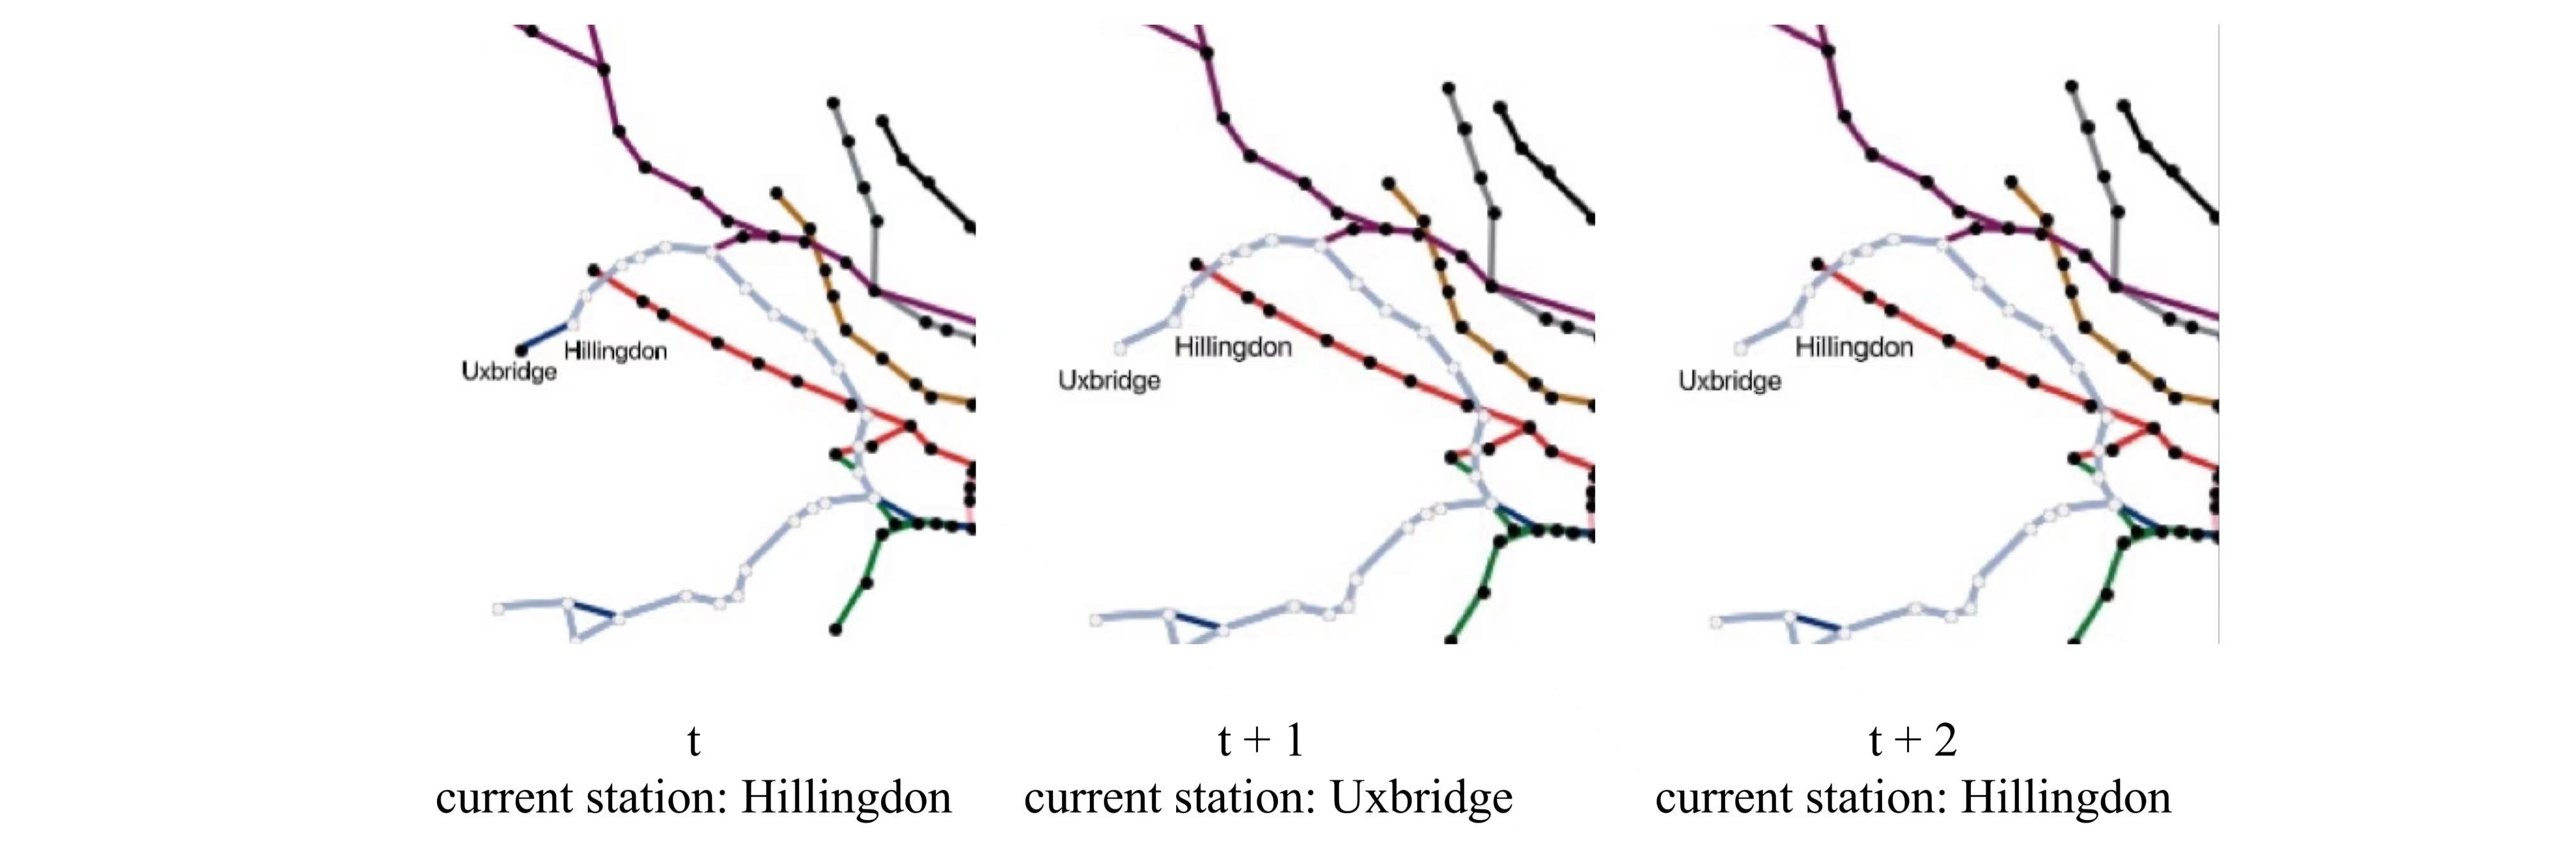

Instead, we can see this task as a typical Travelling Salesman Problem.

The famous Travelling Salesman Problem asks the following question: "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?". TSPs can be modelled as an undirected weighted graph, such that cities are the graph's nodes, paths are the graph's edges, and a path's distance is the edge's weight. It is a minimization problem starting and finishing at a specified node after having visited every other node exactly once. Often, the model is a complete graph (i.e., each pair of nodes is connected by an edge). 


If we consider the concept of *city* representing station, and the concept of *distance* representing journey time, then the Tube Challenge is similar to the TSP with a few notable differences:

1.   Although the London Underground network is a connected graph (i.e., there is always a *path* between every pair of stations), it is not complete (there isn't always an *edge* between every pair of stations). The number of available actions from a station is only the number of stations it directly connects to.

2.   It is not possible to visit each station exactly once to complete the Tube Challenge.

3.   It is not required to start and finish at the same station. 

This problem can be reduced to the classic TSP problem with a processing step:

* When no edge exists between two stations $i$ and $j$, add an edge connecting them, and set the distance $d_{i,j}$ between $i$ and $j$ as the length of the shortest route between them. 

This will complete the graph and will not affect the optimal route. 

After this, we can require that each station be visited *exactly once*.

The intuition is as follows. All the stations in the London Underground network are connected to one another. When the graph is not complete, one needs to visit a station more than once to complete the Tube Challenge. However, the only reason to revisit a *visited* station, is to pass through it in order to reach an *unvisited* station. When the graph is complete, we will never need to, and it is never optimal to revisit a visited station. 

This problem will still be different from the TSP in one way: 
* We do not require it to start and finish at the same station. 


To effectively 'add edges' between every pair of stations, we compute a $275 \times 275$ distance matrix.

In [ ]:
distance_x = np.zeros((275, 275))

A shortest path algorithm (here we are using Dijkstra's algorithm) calculates the shortest path between each station pairs. We use it to fill a distance matrix. Note that the 1km transit penalty is also included in the calculation.

In [ ]:
graph_distance = nx.Graph()
for connection_id, connection in connections__.iterrows():
    graph_distance.add_edge(connection['station1'], connection['station2'], weight = connection['distance'])

In [ ]:
def distance(start, end):
    journey_distance = nx.shortest_path_length(graph_distance, start, end, weight='weight')
    return journey_distance

In [ ]:
## matching platform index with station index
id275 = tubes_unique['id'].to_list()
index = range(0, 275)
id_dict = dict(zip(id275, index))

In [ ]:
## for each station pair, calculate length of shortest path and add to the distance matrix
## this cell can take 3 minutes to run
for i in range(0, 384):
  for j in range(0, 384):
    distance_x[id_dict[tubes[tubes['idx']==i]['id'].item()], id_dict[tubes[tubes['idx']==j]['id'].item()]] = distance(i, j)

In [ ]:
#loading the distance matrix save in the current working directory
distance_x = np.load('distance_x.npy')

<a name="methods"></a>
# Methods


The TSP has been solved by both exact and heuristic algorithms. The most direct solution would be to try all permutations (ordered combinations) of possible paths and see which one is the cheapest. However, TSP are NP-hard problems, meaning that they are exponentially hard to solve with brute force. The complexity and hence running time for the permutation approach is within a polynomial factor of $O(n!)$, so this method becomes impractical even for only a dozen of cities. The exact dynamic programming algorithm for TSP also has a complexity of $O(n^2 2^n)$, making it also infeasible to scale up.

State of the art TSP solvers often use both carefully hand-engineered heuristics and a combination of different algorithms. However, it is difficult to apply existing heuristics to newly encountered problems, as stated in the No Free Lunch Theoreom, "any two optimization algorithms are equivalent when their performance is averaged across all possible problems" (Wolpert & Macready, 2005). Reinforcement learning can offer a more general framwork for TSP-like problem. Adding extra information like train delay estimation is also feasible if we integrate a prediction algorithm (e.g. with Neural Networks).

As reinforcement learning methods have the potential of giving good, generalizable solutions to TSPs with reduced complexity, this section will show some simple framework to apply reinforcement learning methods to solve the Tube Challenge.

<a name="random"></a>
##Baseline Random Policy

First we will need a baseline of random decision-making to compare the algorithms to.

These are the steps of the random algorithm:

1.   Initialize an arbitrary station as the starting station. Mark it as visited. Mark all other stations as unvisited.
2.   Choose a random station $a$ from all the unvisited stations connected to the current station $s$.
3.   Set $a$ as the current vertex $s$. Mark $a$ as visited.
4.   If all the stations are visited, then terminate. Else, go to step 2.

In [ ]:
for r in range(0, 10):
  episodes = 1000
  total_distances = []
  for i in range(episodes):
    #initialize with a starting state
    s = 0
    total_distance = 0
    #making a 'completed' dict
    keys = range(0, 275)
    completed = dict(zip(keys, [False] * 275))
    states_memory = [s]
    completed[s] = True
    step = 0
    done = False
    while not done:     
      #choosing action
      a = np.random.choice([x for x in range(275) if x not in states_memory])
      distance = distance_x[s, a]
      #update distance and 'completed' dict
      total_distance += distance
      states_memory.append(a)
      completed[a] = True
      #update state
      s = a
      done = all(value == True for value in completed.values())
      step += 1
    total_distances.append(total_distance)
  #np.save('values/random/distances_r{}.npy'.format(r), total_distances) 

<a name="nn"></a>
##Nearest Neighbor Policy


The Nearest Neighbor method is also one of the popular methods for solving TSP, and will be another baseline policy we compare the Q-Learning algorithms to. 

These are the steps of the algorithm:
1.   Initialize an arbitrary station as the starting station. Mark it as visited. Mark all other stations as unvisited.
2.   Find out the shortest edge connecting the current station $s$ to an unvisited station $a$.
3.   Set $a$ as the current vertex $s$. Mark $a$ as visited.
4.   If all the stations are visited, then terminate. Else, go to step 2.

In [ ]:
def run_nn(s):
  #initialize with a starting state
  s = s
  total_distance = 0
  lengths = []
  #making a 'completed' dict
  keys = range(0, 275)
  completed = dict(zip(keys, [False] * 275))
  states_memory = [s]
  completed[s] = True
  step = 0
  done = False
  while not done:     
    #choosing action
    distance = np.amin(distance_x[s, [x for x in range(275) if x not in states_memory]])
    a = int(np.where(distance_x[s, :] == distance)[0])
    distance = distance_x[s, a]
    #update distance and 'completed' dict
    total_distance += distance
    lengths.append(distance)
    states_memory.append(a)
    completed[a] = True
    #update state
    s = a
    done = all(value == True for value in completed.values())

  return total_distance, lengths

In [ ]:
total_distance, lengths = run_nn(273)

<a name="q"></a>
## Q learning

Q learning is one of the most popular class of reinforcement learning algorithms, and there are also variants including double Q-learning, fitted Q-iteration, and deep Q-network. The main idea of the Q learning is to learn the optimal Q-function $Q^{π^{opt}}$ based on the Bellman optimality
equation and derive the optimal policy

<center>$$π^{opt}(s) =  \arg\max_{a} Q^{π^{opt}}(s, a)$$</center>

Our case is one of tabular Q-learning, as it is a finite Markov Decision Process with discrete state and action. Hence, we want to evaluate a Q matrix where the rows are the different states (all the stations) and the columns the possible actions to take in this state, hence the next station to visit. 



These are the steps of the algorithm:

1.   Initialize an arbitrary station as the starting station. Mark it as visited. Mark all other stations as unvisited.

2.   *   with probability $1 - \epsilon$ : (Greedy Policy) According to the Q values, choose the best unvisited station $a$ to move to from the current station $s$
     *   with probability $\epsilon$ : (Random Policy) Choose a random station $a$ from all the unvisited stations connected to the current station $s$.

3.   Set $a$ as the current vertex $s$. Mark $a$ as visited. Update Q value.

4.   If all the stations are visited, then terminate. Else, go to step 2.

In [ ]:
def q_learning(qsa, next_qs, r, alpha=0.1, gamma=1.0):  
    return qsa + alpha * (r + gamma * np.max(next_qs) - qsa)

In [ ]:
def run_q(episodes, epsilon_decay):
  total_distances = []
  
  #q values lookup table
  Q = np.zeros((275, 275))
  epsilon = 1
  epsilon_min = 0.01
  for i in range(episodes):
    #initialize with a starting state
    s = 0
    total_distance = 0
    #making a 'completed' dict
    keys = range(0, 275)
    completed = dict(zip(keys, [False] * 275))
    states_memory = [s]
    completed[s] = True
    done = False
    #epsilon decay
    if epsilon > epsilon_min:
      epsilon *= epsilon_decay

    while not done:     
      #the q 
      q = np.copy(Q[s,:])
      q[states_memory] = -np.inf

      #choosing action base on epsilon greedy policy
      if np.random.rand() > epsilon:
        a = np.argmax(q)
      else:
        a = np.random.choice([x for x in range(275) if x not in states_memory])
      distance = distance_x[s, a]

      #update distance and 'completed' dict
      total_distance += distance
      states_memory.append(a)
      completed[a] = True

      #update q values ('action' = 'next_state')
      Q[s, a] = q_learning(Q[s, a], Q[a, :], -distance)

      #update state
      s = a
      done = all(value == True for value in completed.values())
    total_distances.append(total_distance)
  return total_distances, Q

<a name="dq"></a>
## Double Q- learning

The Q Learning algorithm tends to overestimate Q values due to its maximization bias. It involves both a maximization during greedy-action selection, and a maximization during value evaluation. Because of high variances in distance, it is quite possible that the initial few estimates of the actions might be more positive or negative. As the same samples are being used for both action selection and action-value estimation, if an action’s value was overestimated, it will be chosen as the best action, and its overestimated value would be used as the target. 

Instead, we can have two different action-value estimates as mentioned in the above equation. The “best” action can then be chosen based on the values of the first action-value estimate and the target can be decided based on the second action-value estimate. Since the samples are stochastic, it is less likely that both the halves of the samples are overestimating the same action. 
 
Though this solution does combat the over-estimation problem, the number of samples used to learn each value estimate $Q_1$ and $Q_2$ is also reduced by half. As a result, the double Q learning algorithm might need more samples to reach a good performance.

These are the steps of the algorithm:

1.   Initialize an arbitrary station as the starting station. Mark it as visited. Mark all other stations as unvisited.

2.   *   with probability $1 - \epsilon$ : (Greedy Policy) According to the values of $Q_1 + Q_2$, choose the best unvisited station $a$ to move to from the current station $s$
     *   with probability $\epsilon$ : (Random Policy) Choose a random station $a$ from all the unvisited stations connected to the current station $s$.

3.   Set $a$ as the current vertex $s$. Mark $a$ as visited. 
    *   with probability $0.5$: Update $Q_1$ (with value from $Q_2$).
    *   with probability $0.5$: Update $Q_2$ (with value from $Q_1$).



4.   If all the stations are visited, then terminate. Else, go to step 2.

In [ ]:
def run_dq(episodes, epsilon_decay):
  epsilon_min = 0.01
  total_distances = []

  #q values lookup table
  Q1 = np.zeros((275, 275))
  Q2 = np.zeros((275, 275))
  epsilon = 1

  for i in range(episodes):
    #initialize with a starting state
    s = 0
    total_distance = 0
    #making a 'completed' dict
    keys = range(0, 275)
    completed = dict(zip(keys, [False] * 275))
    states_memory = [s]
    completed[s] = True
    done = False
    #epsilon decay
    if epsilon > epsilon_min:
      epsilon *= epsilon_decay

    while not done:     
      #the q 
      q1 = np.copy(Q1[s,:])
      q2 = np.copy(Q2[s,:])
      q = q1+q2
      q[states_memory] = -np.inf

      #choosing action base on epsilon greedy policy
      if np.random.rand() > epsilon:
        a = np.argmax(q)
      else:
        a = np.random.choice([x for x in range(275) if x not in states_memory])
      distance = distance_x[s, a]

      #update distance and 'completed' dict
      total_distance += distance
      states_memory.append(a)
      completed[a] = True

      #update q values ('action' = 'next_state')

      if np.random.binomial(1, 0.5) == 1:
        Q1[s, a] = q_learning(Q1[s, a], Q2[a, :], -distance)
      else:
        Q2[s, a] = q_learning(Q2[s, a], Q1[a, :], -distance)

      #update state
      s = a
      done = all(value == True for value in completed.values())
      step += 1
    total_distances.append(total_distance)
  return total_distances, Q1, Q2

<a name="dqn"></a>
##Deep Q-Network

Deep Q-Learning replaces the regular Q-table with a neural network. 

These are the steps of the algorithm:

At the start of each episode, set the weights of the target network equal to the weights of the policy network. Then: 

  1.  Initialize an arbitrary station as the starting station. Mark it as visited. Mark all other stations as unvisited.

  2.   *   with probability $1 - \epsilon$ : (Greedy Policy) According to the prediction of the policy network, choose the best unvisited station $a$ to move to from the current station $s$
      *   with probability $\epsilon$ : (Random Policy) Choose a random station $a$ from all the unvisited stations connected to the current station $s$.

  3.  Set $a$ as the current station $s$. Mark $a$ as visited. Sample a random mini-batch of state-transitions from experience. For each state-transition in the minibatch, according to the prediction of the target network, perform a gradient descent step to update weights of the policy Network.

  4.  If all the stations are visited, then terminate. Else, go to step 2.



In [ ]:
from collections import deque
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

In [ ]:
def build_compile_model():
    model = Sequential()
    model.add(Embedding(1, 275, input_length=1))
    model.add(Dense(24, input_dim=1, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(275, activation='linear'))
    model.compile(loss='mse', optimizer='Adam')
    return model

In [ ]:
q_network = build_compile_model()
target_network = build_compile_model()

In [ ]:
episodes = 1
epsilon_decay = 0.99
batch_size = 16
total_distances = []
expirience_replay = deque(maxlen=200)
epsilon = 1
epsilon_min = 0.01

for i in range(episodes):
  #initialize with a starting state
  s = 0
  total_distance = 0
  #making a 'completed' dict
  keys = range(0, 275)
  completed = dict(zip(keys, [False] *275))
  states_memory = [s]
  completed[s] = True
  done = False
  
  #epsilon decay
  if epsilon > epsilon_min:
    epsilon *= epsilon_decay      
  while not done:    
    if np.random.rand() > epsilon: 
      q = q_network.predict(np.array([s]))
      q[0][0][states_memory] = -np.inf
      a = np.argmax(q)
    else:
      a = np.random.choice(np.array([x for x in range(275) if x not in states_memory]))
    distance = distance_x[s, a]
    states_memory.append(a)
    total_distance += distance
    completed[a] = True
    done = all(value == True for value in completed.values())
    expirience_replay.append((s, a, -distance, a, done))
    if done:
            
    if len(expirience_replay) > batch_size:
        minibatch = random.sample(expirience_replay, batch_size)
        for state, action, reward, next_state, terminated in minibatch:
            target = q_network.predict(np.array([state]))
            if terminated == True:
                target[0][0][action] = reward
            else:
                t = target_network.predict(np.array([next_state]))
                target[0][0][action] = reward + 0.1 * np.amax(t)
            q_network.fit(np.array([state]), target, epochs=1, verbose=0)
    #update state   
    s = a
  target_network.set_weights(q_network.get_weights())   
  total_distances.append(total_distance)

<a name="results"></a>
# Experiments, Results and Discussions

<a name="details"></a>
#### Implementation Details

For the Q learning and Double Q learning algorithms, the learning rate alpha is set to 0.1 and gamma is set to 1.0. We trained both algorithms for 1000, 2000, and 4000 episodes, each for 10 runs. As number of episodes increased, the Epsilon decay factor is also increased to allow more explorations. This parameter setting is showed in the table below.



<center></center>


  |   Number of Episodes($n$)  | Epsilon Decay Factor($decay$) | $decay^{n}$ |
 |  -----------  |-------------------|-------------------|
| <center>1000 </center> | <center>0.999</center>|0.3677
|  <center>2000 </center>| <center>0.9995</center>| 0.3678
|  <center>4000 </center>|<center> 0.9997</center>|0.3011

The starting station is set to be Acton Town which is in alphabetical order the first station in the network. Under an optimal policy for TSP, it should not matter which station we start at, as it would not affect the length of the optimal route. However, it might have an effect on suboptimal routes.

Both the Q learning and Double Q learning algorithm take about 15 minutes to run 1000 episodes on a laptop with 1.1 GHz Quad-Core Intel Core i5 Processor. After each run, he total distances and the Q values for each run are saved as `.npy` files.

Solving a TSP with 275 nodes is a daunting task especially when we use simple algorithms and have limited computational resources: the Deep Q Network algorithm took more than 10 minutes to run one episode, therefore is not a viable option for us, especially since the basic DQN can be sample inefficient and potentially need more number of episodes to reach good performance. Also, a TSP with 275 nodes is tricky to optimize even with state of the art methods. While we do not expect any of our proposed methods to find a truly optimal route, it is nevertheless interesting to investigate the behaviours of the proposed methods. 

An interesting extension of this project would be to solve a smaller tube challenge (such as to visit all stations in Zone 1) and try to implement some potentially better performing but also more computationally costly algorithms. 


####loading saves distances

In [ ]:
Distances = np.zeros((10, 1000))
for i in range(1,10):
   Distances[i] = np.load('values/random/distances_r{}.npy'.format(i)) 
total_distance_random = np.average(Distances, axis=0)

Distances = np.zeros((10, 1000))
for i in range(0,10):
   Distances[i] = np.load('values/q/distances_r{}.npy'.format(i)) 
total_distance_q1000 = np.average(Distances, axis=0)

Distances = np.zeros((10, 1000))
for i in range(0,10):
   Distances[i] = np.load('values/double_q/distances_r{}.npy'.format(i)) 
total_distance_dq1000 = np.average(Distances, axis=0)

Distances = np.zeros((10, 2000))
for i in range(0,10):
   Distances[i] = np.load('values/q/distances_2000_r{}.npy'.format(i)) 
total_distance_q2000 = np.average(Distances, axis=0)

Distances = np.zeros((10, 2000))
for i in range(0,10):
   Distances[i] = np.load('values/double_q/distances_2000_r{}.npy'.format(i)) 
total_distance_dq2000 = np.average(Distances, axis=0)

Distances = np.zeros((10, 4000))
for i in range(0,10):
   Distances[i] = np.load('values/4000/distances_q_r{}.npy'.format(i)) 
total_distance_q4000 = np.average(Distances, axis=0)

Distances = np.zeros((10, 4000))
for i in range(0,10):
   Distances[i] = np.load('values/4000/distances_dq_r{}.npy'.format(i)) 
total_distance_dq4000 = np.average(Distances, axis=0)

#### loading saved Q values

In [ ]:
Q = np.zeros((10, 275, 275))
for i in range(0,10):
  Q[i] = np.load('values/q/Q_r{}.npy'.format(i)) 
Q_q1000_avg = np.average(Q, axis=0)

Q = np.zeros((10, 275, 275))
for i in range(0,10):
  Q[i] = np.load('values/q/Q_2000_r{}.npy'.format(i)) 
Q_q2000_avg = np.average(Q, axis=0)

Q = np.zeros((10, 275, 275))
for i in range(0,10):
  Q[i] = np.load('values/4000/Q_4000_r{}.npy'.format(i)) 
Q_q4000_avg = np.average(Q, axis=0)

Q1 = np.zeros((10, 275, 275))
Q2 = np.zeros((10, 275, 275))
for i in range(0,10):
  Q1[i] = np.load('values/double_q/q1_r{}.npy'.format(i)) 
  Q2[i] = np.load('values/double_q/q2_r{}.npy'.format(i)) 
Q_dq1000_avg = np.average(Q1, axis=0) + np.average(Q2, axis=0)

Q1 = np.zeros((10, 275, 275))
Q2 = np.zeros((10, 275, 275))
for i in range(0,10):
  Q1[i] = np.load('values/double_q/q1_2000_r{}.npy'.format(i)) 
  Q2[i] = np.load('values/double_q/q2_2000_r{}.npy'.format(i)) 
Q_dq2000_avg = np.average(Q1, axis=0) + np.average(Q2, axis=0)

Q1 = np.zeros((10, 275, 275))
Q2 = np.zeros((10, 275, 275))
for i in range(0,10):
  Q1[i] = np.load('values/4000/q1_r{}.npy'.format(i)) 
  Q2[i] = np.load('values/4000/q2_r{}.npy'.format(i)) 
Q_dq4000_avg = np.average(Q1, axis=0) + np.average(Q2, axis=0)

### Performance of the Q learning algorithms: 

####Total Distance during training

The Tube Challenge is a minimization problem where the objective is to minimize the distance it takes to visit every stations. Therefore, total distance is the most important metric for evaluating performances in this task. 

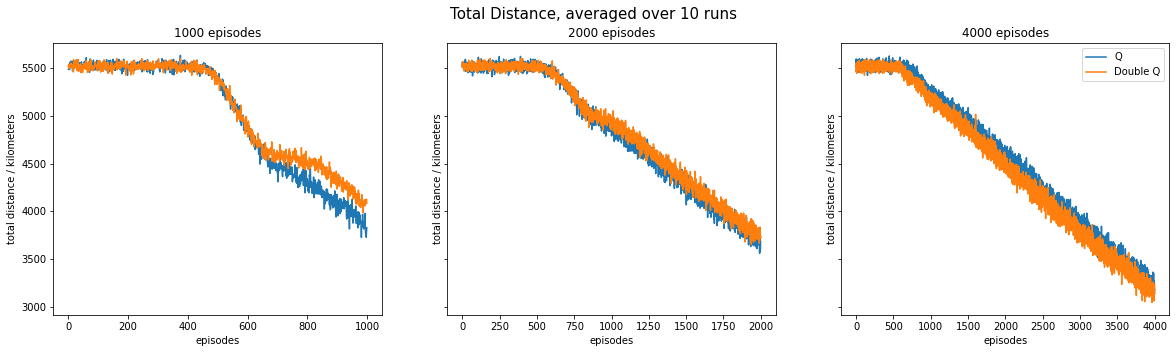

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), sharey=True)
fig.suptitle('Total Distance, averaged over 10 runs', size = 15)
axes[0].plot(total_distance_q1000, label="Q")
axes[0].plot(total_distance_dq1000, label="Double Q")
axes[0].set_title('1000 episodes')
axes[1].plot(total_distance_q2000, label="Q")
axes[1].plot(total_distance_dq2000, label="Double Q")
axes[1].set_title('2000 episodes')
axes[2].plot(total_distance_q4000, label="Q")
axes[2].plot(total_distance_dq4000, label="Double Q")
axes[2].set_title('4000 episodes')
for ax in axes:
    ax.set(xlabel='episodes', ylabel='total distance / kilometers')
plt.legend(loc="upper right")
fig.show()

As the figures above show, when we start training and experiencing the same problem overtime, the agent learns about the environment takes less and less distance to complete the Tube Challenge. We can also see there are two distinc phases during training. In the first phase, until about the 500th episode, the agent is still exploring the different routes. Indeed, with the epsilon decay method, the agent is mostly choosing random actions at each step. In the second phase, as epsilon is lowering, the agent starts exploiting what it has learnt, taking less and less random actions and make decisions based more on the Q values.

Performance during training improves if we train for more episodes. With 275 stations there are $275!$ possible routes, and we do need a large enough sample of routes to train a reinforcement learning algorithm. Due to limitations of computational resources, we only trained up to 4000 episodes, but we do expect the algorithms to perform even better with more episodes. 

In my experiments we do not see a significant difference between the performance of Q learning and Double Q learning algorithms. In the 1000-episodes runs, however, Double Q learning performs worse than Q learning. We think this is because in Double Q learning, the number of samples used to learn each value estimate  $Q_1$and  $Q_2$  is  reduced by half, so with a smaller number of episodes, the inadequacy of samples makes it perform worse than Q learning. With more episodes, this difference in performance seems to disappear. We think with even more episodes, we could start to see Double Q performing better than Q learning.

####Performance under Optimal Policy

We have saved the Q values for each run. Now we can derive the optimal policy as:

$$π^{opt}(s) =  \arg\max_{a} \overline{Q^{π^{opt}}}(s, a)$$ 

Then, we calculate the total distance under optimal policy. We choose Acton Town as the starting station, same as the starting station we used during training. With more episodes, we get shorter optimal routes. Q Learning's performance under optimal policy is slightly better than Double Q, again we think this is partly due to insuffcient samples.


<center>Table 2: Distance of optimal route starting from Acton Town under $π^{opt}$, averaged over 10 runs, in kilometers</center>


|                               |   Q-Learning  | Double Q-Learning |
| -----------                   |  -----------  |-------------------|
| <center>1000 episodes</center>| <center>1196.2 </center> | <center>1551.3</center>
|  <center>2000 episodes</center>| <center> 847.5 </center>| <center>960.1</center>
|  <center>4000 episodes</center>|<center> 736.9</center>|<center>788.9 </center>

##### function to calculate total distance under optimal policy

In [ ]:
def ideal_distance(Q, s):
  total_distance = 0
  lengths = []
  #making a 'completed' dict
  keys = range(0, 275)
  completed = dict(zip(keys, [False] * 275))
  states_memory = []
  completed[s] = True
  done = False

  while not done:     
    #the q 
    q = np.copy(Q[s,:])
    q[states_memory] = -np.inf
    a = np.argmax(q)
    distance = distance_x[s, a]
    #update distance and 'completed' dict
    total_distance += distance
    states_memory.append(s)
    completed[s] = True
    lengths.append(distance)
    #update state
    s = a
    done = all(value == True for value in completed.values())
  return total_distance , lengths

#####generating the data in the above table 

In [ ]:
ideal_distances =[]
lengths = np.zeros((10, 274))
for i in range(0,10):
  Q = np.load('values/q/Q_r{}.npy'.format(i))
  d , l = ideal_distance(Q, 0)
  ideal_distances.append(d)
  lengths[i] = [x for x in l if x !=0]
print(sum(ideal_distances)/len(ideal_distances))
lengths_q1 = np.average(lengths, axis=0)

1196.2454684846248


In [ ]:
ideal_distances =[]
lengths = np.zeros((10, 274))
for i in range(0,10):
  Q1 = np.load('values/double_q/q1_r{}.npy'.format(i))
  Q2 = np.load('values/double_q/q2_r{}.npy'.format(i))
  Q = Q1 + Q2
  d , l = ideal_distance(Q, 0)
  ideal_distances.append(d)
  lengths[i] = [x for x in l if x !=0]
print(sum(ideal_distances)/len(ideal_distances))
lengths_dq1 = np.average(lengths, axis=0)

1551.25643851313


In [ ]:
ideal_distances =[]
lengths = np.zeros((10, 274))
for i in range(0,10):
  Q = np.load('values/q/Q_2000_r{}.npy'.format(i))
  d , l = ideal_distance(Q, 0)
  ideal_distances.append(d)
  lengths[i] = [x for x in l if x !=0]
print(sum(ideal_distances)/len(ideal_distances))
lengths_q2 = np.average(lengths, axis=0)

847.4856272320218


In [ ]:
ideal_distances =[]
lengths = np.zeros((10, 274))
for i in range(0,10):
  Q1 = np.load('values/double_q/q1_2000_r{}.npy'.format(i))
  Q2 = np.load('values/double_q/q2_2000_r{}.npy'.format(i))
  Q = Q1 + Q2
  d , l = ideal_distance(Q, 0)
  ideal_distances.append(d)
  lengths[i] = [x for x in l if x !=0]
print(sum(ideal_distances)/len(ideal_distances))
lengths_dq2 = np.average(lengths, axis=0)

960.1466420228901


In [ ]:
ideal_distances =[]
lengths = np.zeros((10, 274))
for i in range(0,10):
  Q = np.load('values/4000/Q_4000_r{}.npy'.format(i))
  d , l = ideal_distance(Q, 0)
  ideal_distances.append(d)
  lengths[i] = [x for x in l if x !=0]
print(sum(ideal_distances)/len(ideal_distances))
lengths_q4 = np.average(lengths, axis=0)

736.9021866946501


In [ ]:
ideal_distances =[]
lengths = np.zeros((10, 274))
for i in range(0,10):
  Q1 = np.load('values/4000/q1_r{}.npy'.format(i))
  Q2 = np.load('values/4000/q2_r{}.npy'.format(i))
  Q = Q1 + Q2
  d , l = ideal_distance(Q, 0)
  ideal_distances.append(d)
  lengths[i] = [x for x in l if x !=0]
print(sum(ideal_distances)/len(ideal_distances))
lengths_dq4 = np.average(lengths, axis=0)

788.845229015141


##### Averaging Q values

In [ ]:
for Q in [Q_q1000_avg, Q_q2000_avg, Q_q4000_avg, Q_dq1000_avg, Q_dq2000_avg, Q_dq4000_avg]:
  d , l = ideal_distance(Q, 0)
  print(d)

<center>Table 3: Distance of optimal route starting from Acton Town, under a policy maximizing averaged Q values, in kilometers</center>

|                               |   Q-Learning  | Double Q-Learning |
| -----------                   |  -----------  |-------------------|
|  <center>1000 episodes, 10 runs</center>|<center>712.0</center>| <center>761.1</center>
|  <center>2000 episodes, 10 runs</center>|<center>701.9</center>| <center>709.5</center>
|  <center>4000 episodes, 10 runs</center>|<center>676.7 </center>|<center> 699.2</center>

Since we did 10 runs of each setting, we averages the Q values from 10 runs,and we find a policy:

$$ π(s,a) =  \arg\max_{a} \overline{Q^{π^{opt}}}(s, a)$$ 

Then, we calculate the total distance under this average policy. The performance under this policy is better than the ones in the last table, especially for the 1000 episodes row. We think this is because with two small a sample size to learn from, the Q values contain more bias, and because at least a part of this bias is stochastic, taking averages reduces them.

Under a policy maximizing averaged Q values, after 10 runs of 4000 episodes of the Q learning algorithm, the found optimal route is 676.7 km.

#### Step Length 

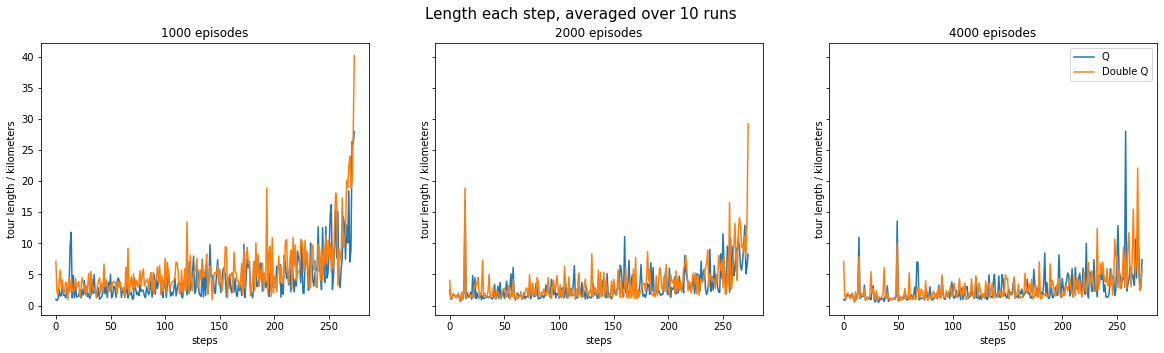

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), sharey=True)
fig.suptitle('Length each step, averaged over 10 runs', size = 15)
axes[0].plot(lengths_q1, label="Q")
axes[0].plot(lengths_dq1, label="Double Q")
axes[0].set_title('1000 episodes')
axes[1].plot(lengths_q2, label="Q")
axes[1].plot(lengths_dq2, label="Double Q")
axes[1].set_title('2000 episodes')
axes[2].plot(lengths_q4, label="Q")
axes[2].plot(lengths_dq4, label="Double Q")
axes[2].set_title('4000 episodes')
for ax in axes:
    ax.set(xlabel='steps', ylabel='tour length / kilometers')
plt.legend(loc="upper right")
fig.show()

The above figure shows the length of the 274 steps the agent made, averaged over 10 runs. We can see that as the number of episodes increases, the agents learned to take shorter steps. This is another evidence that the agent is learning. The lengths of their steps also showed lower variances. 

The agents are still taking longer steps towards the end of its tour, we think this indicates insufficient learning.





####Comparison with random policy and Nearest Neighbor policy

In [ ]:
print(f'The average total distance under a random policy is {np.average(total_distance_random)} kilometers.')

The average total distance under a random policy is 4970.7174367900825 kilometers.


Text(0.5, 1.0, 'Total distance under a random policy, averaged over 10 runs')

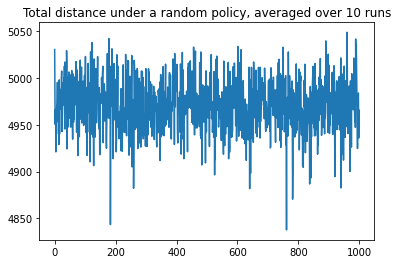

In [ ]:
plt.plot(total_distance_random)
plt.title('Total distance under a random policy, averaged over 10 runs')

Compared with the baseline random policy, my algorithms have achieved significant improvement (from 4971 km to 677 km). One should note that tranforming the Tube Challenge to a TSP already gives better results than [the naive implementation](https://colab.research.google.com/drive/1O_HJeNMZtpzEMX3Wx9e2DW_GCEe4ax2X?usp=sharing), even for the random policy. Taking random steps in over environment gives better results than taking random steps in the Underground network. 

In [ ]:
d, l = run_nn(0)
print(f'Under a Nearest Neighbor policy, the total distance is {d} kilometers.')

Under a Nearest Neighbor policy, the total distance is 676.1267921864381 kilometers.


Performance under the Nearest Neighbor policy is almost exactly the same as our best result. In the next section, we visualize these two routes and show that the two routes are also sililar. 

We think this could either be because our algorithms are biased towards acting greedy and taking the shortest step; or that the truly optimal solution to the TSP representation of the Tube Challenge is a lot similar to the Nearest Neighbor solution.

#### Visualising the routes under optimal policies: do they make sense?

##### create a graph representation

In [ ]:
routes = pd.read_csv('routes.txt')

In [ ]:
connections_t = pd.DataFrame(columns=['line',	'line_name',	'line_colour', 'station1', 'station1_name', 'station1_long','station1_lat', 'station2', 'station2_name', 'station2_long','station2_lat'])
connections_t = connections_t.iloc[0:0]
for index, row in line_definitions[line_definitions['line']<13].iterrows():
  connections_t = connections_t.append({'line': row[2],
                                        'line_name': routes[routes['line']==row[2]]['name'].item(),
                                        'line_colour': routes[routes['line']==row[2]]['colour'].item(),
                                        'station1': tubes_unique[tubes_unique['id']==row[0]]['id'].item(),
                                        'station1_name': tubes_unique[tubes_unique['id']==row[0]]['name'].item(),
                                        'station1_long': tubes_unique[tubes_unique['id']==row[0]]['longitude'].item(),
                                        'station1_lat': tubes_unique[tubes_unique['id']==row[0]]['latitude'].item(),
                                        'station2': tubes_unique[tubes_unique['id']==row[1]]['id'].item(),
                                        'station2_name': tubes_unique[tubes_unique['id']==row[1]]['name'].item(),
                                        'station2_long': tubes_unique[tubes_unique['id']==row[1]]['longitude'].item(),
                                        'station2_lat': tubes_unique[tubes_unique['id']==row[1]]['latitude'].item(),
                                        }, ignore_index=True)


In [ ]:
from math import cos, asin, sqrt, pi
def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))
distances=[]
for index, row in connections_t.iterrows():
  distances.append(distance(row[6], row[5], row[10], row[9]))
connections_t['distance'] = distances

In [ ]:
graph_distance = nx.Graph()
for connection_id, connection in connections_t.iterrows():
    graph_distance.add_edge(connection['station1'], connection['station2'], weight = connection['distance'])

In [ ]:
edgelist = connections_t[['station1', 'station2', 'line_colour', 'distance']]
nodelist = tubes_unique[['id','latitude','longitude']]

In [ ]:
g = nx.Graph()
for i, elrow in edgelist.iterrows():
    g.add_edge(elrow[0], elrow[1], **elrow[2:].to_dict())
for i, nlrow in nodelist.iterrows():
    nx.set_node_attributes(g, {nlrow['id']:  nlrow[1:].to_dict()})  

In [ ]:
node_positions_as_dict = {x[0]: x[1] for x in list(g.nodes(data=True))}
node_positions_final = {key: value for key, value in node_positions_as_dict.items()}
node_positions = {node[0]: (node[1]['longitude'], node[1]['latitude']) for node in list(g.nodes(data=True))}

In [ ]:
line_colours = {
        'ab6612': (171, 102, 18),
        '0076bd': (0, 118, 189),
        'f7dc00': (247, 220, 0),
        'f5a6b3': (245, 166, 179),
        '767b7f': (118, 123, 127),
        '0d6928': (0, 114, 41),
        'df002c': (220, 36, 31),
        '8b004c': (117, 16, 86),
        'f3ba22': (243, 186, 34),
        '000000': (0, 0, 0),
        '002d73': (0, 45, 115),
        '89cbc1': (137, 203, 193)
}

# Convert RGB to [0,1] scale
line_colours = {line: tuple([x / 255.0 for x in rgb]) for line, rgb in line_colours.items()}
options = {
    'edge_color': [line_colours[data['line_colour']] for u,v,data in g.edges(data=True)],
    'width': 1.5,
    'alpha': 1,
}

#####Getting the optimal route given a $Q^{opt}$ and unpacking it to represent stations in real world

In [ ]:
def ideal_route(Q, s):
  total_distance = 0
  #making a 'completed' dict
  keys = range(0, 275)
  completed = dict(zip(keys, [False] * 275))
  states_memory = []
  lengths = []
  completed[s] = True
  done = False

  while not done:     
    #the q 
    q = np.copy(Q[s,:])
    q[states_memory] = -np.inf
    a = np.argmax(q)
    distance = distance_x[s, a]
    lengths.append(distance)
    
    #update distance and 'completed' dict
    total_distance += distance
    states_memory.append(s)
    completed[s] = True
    #update state
    s = a
    done = all(value == True for value in completed.values())
  return states_memory

In [ ]:
def shortest_route(journey):
  route = []
  i = 0
  for x in journey:
    if i < len(journey)-1:
      route.append(nx.shortest_path(graph_distance, journey[i], journey[i+1], weight='weight')[1:])
    i += 1
  return route

In [ ]:
def unpack(journey):
  journey_ = []
  for stop in journey:
    if stop not in journey_:
          journey_.append(stop)

  index =range(0,275)
  id275 = tubes_unique['id'].to_list()
  idx_dict = dict(zip(index, id275))

  journey = []
  for stop in journey_:
    journey.append(idx_dict[stop])

  route = shortest_route(journey)
  route = [item for items in route for item in items]

  route_ = []
  #add first stop heathrow terminal five to the routes 
  route_.append(1)
  for stop in route:
    route_.append(stop)

  route_e = []
  for i in range(0, len(route_)-1):
    route_e.append(route_[i+1])
  routes = pd.DataFrame(columns=['station1',	'station2'])
  routes['station1'] = route_[0:len(route_)-1]
  routes['station2'] = route_e

  name = tubes_unique['name'].to_list()
  name_dict = dict(zip(id275, name))
  return routes

#####Generate an image at each step of the route

In [ ]:
def draw_png(image_path, routes):
  edge_cnter = {}
  g_i_edge_colors = []

  for i, j in routes.iterrows():
      plt.figure(figsize=(6, 4))
      nx.draw(g, pos=node_positions, node_size=4, node_color='black', **options)
      #plt.title('1000 episodes', size=20)
      routes_i = routes[0:i]
      for i in range(len(routes_i)):
          edge_i = frozenset([routes_i.iloc[i][0], routes_i.iloc[i][1]])
      g_i = nx.Graph()
      for i, elrow in routes_i.iterrows():
        g_i.add_edge(elrow[0], elrow[1])
      nx.draw_networkx_nodes(g_i, pos=node_positions, node_size=4, alpha=0.9, node_color='white')
      nx.draw_networkx_edges(g_i, pos=node_positions, edge_color='white', alpha=0.6, width =1.5)
      plt.axis('off') 
      plt.savefig(image_path + 'img{}.png'.format(i), dpi=120, bbox_inches='tight')
      plt.close()

To generate these images, run some code like this:
```
journey = ideal_route(Q_q4000_avg, 0)
routes = unpack(journey)
draw_png('q4000_avg/', routes)
```



In [ ]:
journey = ideal_route(np.load('values/q/Q_r0.npy'), 0)
routes = unpack(journey)
draw_png('q1000_eps/', routes)

##### Making a gif with the saved images

In [ ]:
import glob
import imageio
def make_circuit_video(image_path, movie_filename, fps=5):
    # sorting filenames in order
    filenames = glob.glob(image_path + 'img*.png')
    filenames_sort_indices = np.argsort([int(os.path.basename(filename).split('.')[0][3:]) for filename in filenames])
    filenames = [filenames[i] for i in filenames_sort_indices]
    # make movie
    with imageio.get_writer(movie_filename, mode='I', fps=fps) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)


To generate the gif, run something like this:
```
make_circuit_video('q4000_avg/', 'route_animation.gif', fps=5)
```



In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('route_animation_q_v_nn.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1000 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

<a name="=references"></a>
#References




*   Bello, I., Pham, H., Le, Q., Norouzi, M., Bengio, S. (2017) Neural Combinatorial Optimization with Reinforcement Learning, 
https://doi.org/10.48550/arXiv.1611.09940
*   Qiang Ma, Suwen Ge, Danyang He, Darshan Thaker, Iddo Drori. (2019) Combinatorial Optimization by Graph Pointer Networks and Hierarchical Reinforcement Learning
https://arxiv.org/abs/1911.04936
*   Arthur Delarue, Ross Anderson, Christian Tjandraatmadja. (2020) 
Reinforcement Learning with Combinatorial Actions: An Application to Vehicle Routing
https://proceedings.neurips.cc/paper/2020/hash/06a9d51e04213572ef0720dd27a84792-Abstract.html
*   Gavish, Bezalel; Graves, Stephen C. (1978) The Travelling Salesman Problem and Related Problems
https://dspace.mit.edu/handle/1721.1/5363
*   "Daily Ridership". Transport for London.
https://tfl.gov.uk/corporate/about-tfl/what-we-do
*   Hado Hasselt. (2010) Double Q-learning, 
https://proceedings.neurips.cc/paper/2010/hash/091d584fced301b442654dd8c23b3fc9-Abstract.html
*   Ian Osband, Charles Blundell, Alexander Pritzel, Benjamin Van Roy. (2016) Deep Exploration via Bootstrapped DQN
https://proceedings.neurips.cc/paper/2016/hash/8d8818c8e140c64c743113f563cf750f-Abstract.html